/u/jshera/CL/new_venv/lib/python3.12/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/tmp/ipykernel_46838/3801530437.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issu

✅ Model simclr loaded successfully.
✅ Embeddings loaded successfully.


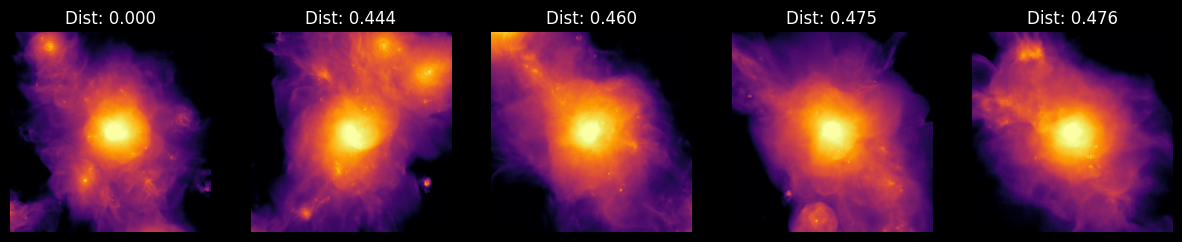

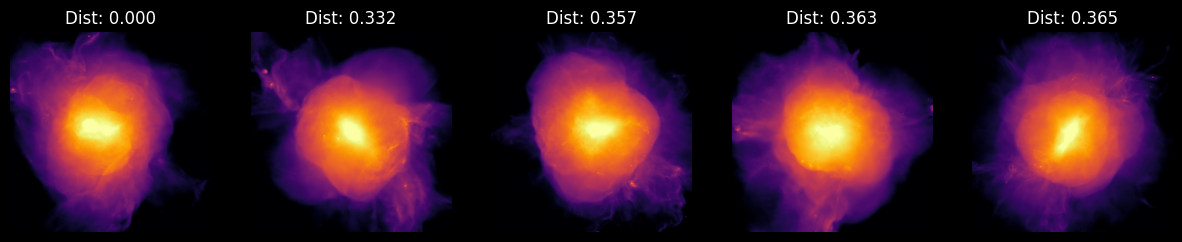

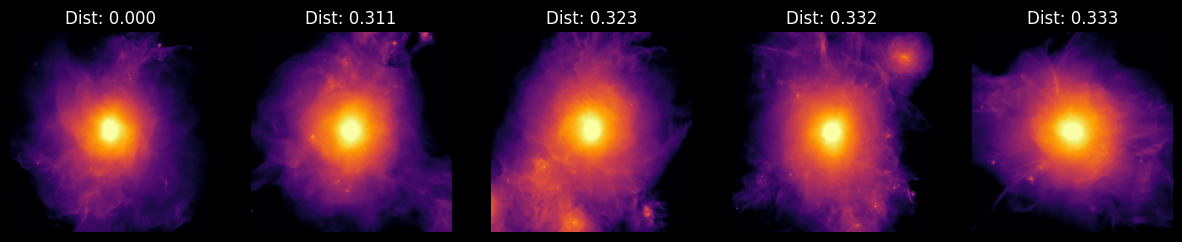

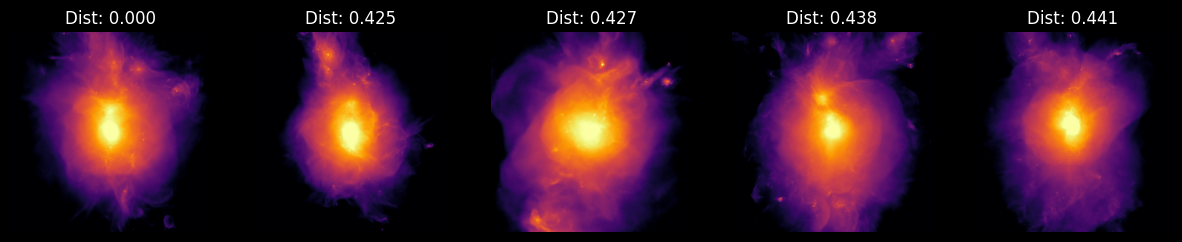

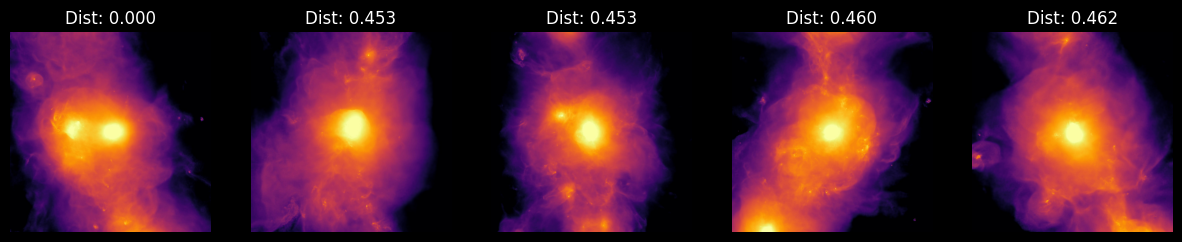

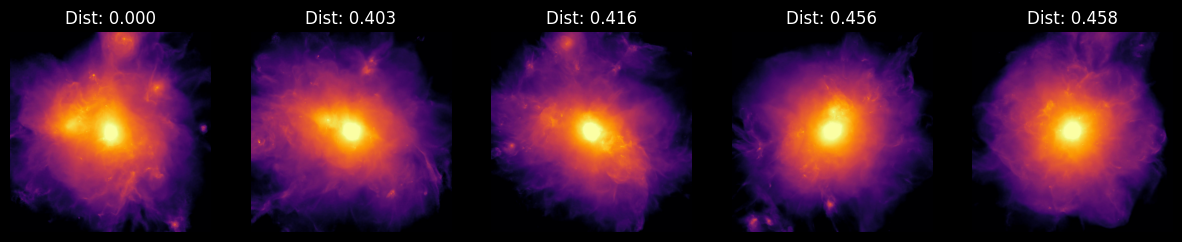

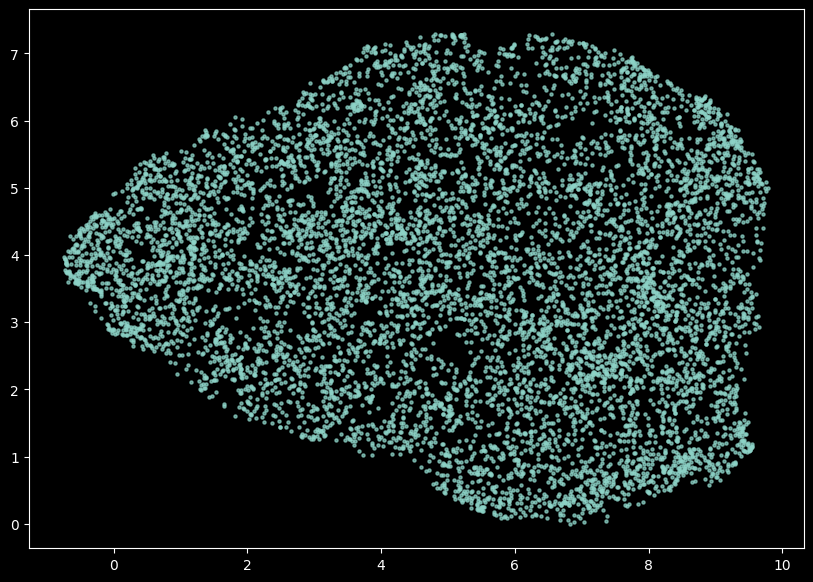

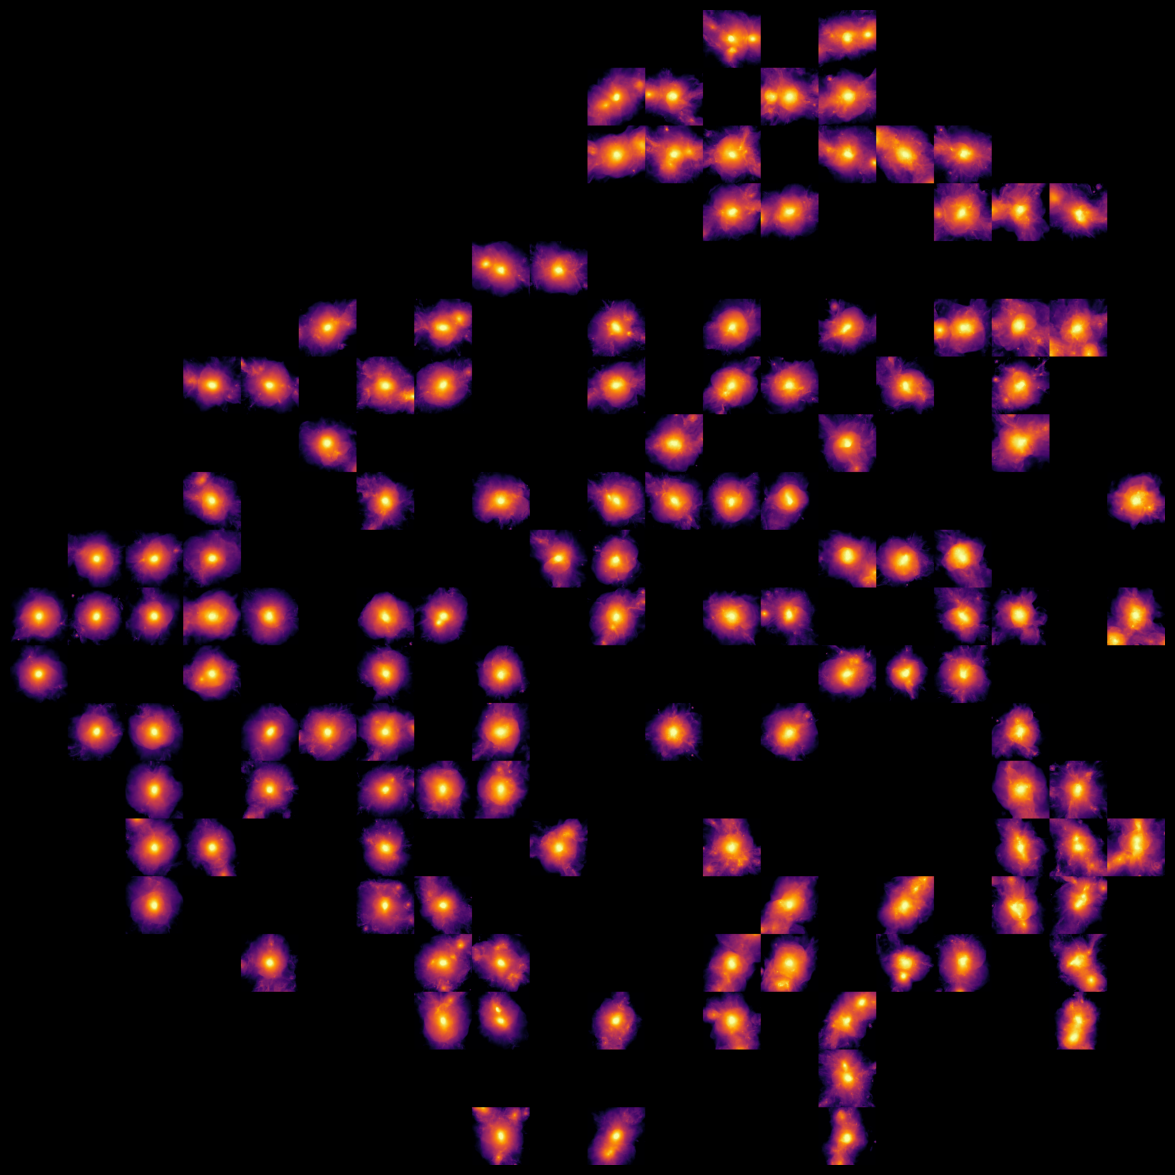

In [1]:
import os
import yaml
import numpy as np
import torch
import matplotlib.pyplot as plt
from postprocessing.plot_knn import plot_knn_examples
from postprocessing.plot_umap import plot_umap_projection
from postprocessing.plot_grid import plot_images_on_grid

# ✅ Load Model Configuration
model_config_path = "configs/model_config.yaml"
with open(model_config_path, "r") as file:
    model_config = yaml.safe_load(file)

selected_model = model_config["model"]["selected_model"]

# ✅ Dynamically Import the Correct Model
if selected_model == "simclr":
    from models.simclr import SimCLRModel as ModelClass
elif selected_model == "dino":
    from models.dino import DINOModel as ModelClass
else:
    raise ValueError(f"Model {selected_model} not supported!")

# ✅ Load Dataset Path from Configuration
dataset_config_path = "configs/dataset_config.yaml"
with open(dataset_config_path, "r") as file:
    dataset_config = yaml.safe_load(file)

DATASET_PATH = dataset_config["dataset"]["data_path"]

# ✅ Check if Model Checkpoint Exists
model_path = "checkpoints/final_model.pth"
if not os.path.exists(model_path):
    raise FileNotFoundError("Model checkpoint not found. Please run `main.sh` first.")

# ✅ Load the Correct Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModelClass()
checkpoint = torch.load(model_path, map_location=device)

# ✅ Handle Different Model Structures
try:
    model.load_state_dict(checkpoint, strict=True)  # Default behavior
except RuntimeError as e:
    print("⚠️ Warning: Mismatch in model state_dict, trying to adjust loading strategy...")
    if selected_model == "dino":
        # DINO models have a student-teacher structure
        student_state_dict = {k.replace("student_backbone.", "backbone."): v for k, v in checkpoint.items() if "student_backbone" in k}
        model.load_state_dict(student_state_dict, strict=False)
    else:
        raise e  # If not DINO, re-raise the error

model.to(device)
model.eval()
print(f"✅ Model {selected_model} loaded successfully.")

# ✅ Load Embeddings
embeddings_path = "embeddings.npy"
embeddings_2d_path = "embeddings_2d.npy"

if os.path.exists(embeddings_path) and os.path.exists(embeddings_2d_path):
    embeddings = np.load(embeddings_path)
    embeddings_2d = np.load(embeddings_2d_path)
    print("✅ Embeddings loaded successfully.")
else:
    raise FileNotFoundError("Embeddings not found. Please run `main.sh` first.")

# ✅ Retrieve Filenames Directly from Dataset Path
image_extensions = (".jpg", ".png", ".jpeg")
filenames = sorted([os.path.join(DATASET_PATH, f) for f in os.listdir(DATASET_PATH) if f.lower().endswith(image_extensions)])

if len(filenames) != len(embeddings):
    raise ValueError(f"⚠️ Mismatch: {len(embeddings)} embeddings vs. {len(filenames)} filenames!")

# Step 1: Visualize Nearest Neighbors
plot_knn_examples(embeddings, filenames, n_neighbors=5, num_examples=6)

# Step 2: UMAP Projection
plot_umap_projection(embeddings_2d)

# Step 3: Plot Images on Grid
plot_images_on_grid(embeddings_2d, filenames, grid_size=20, cell_size=128, step=50)


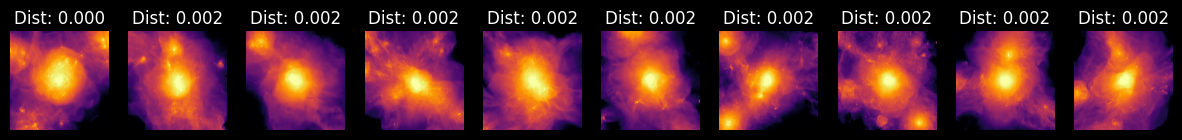

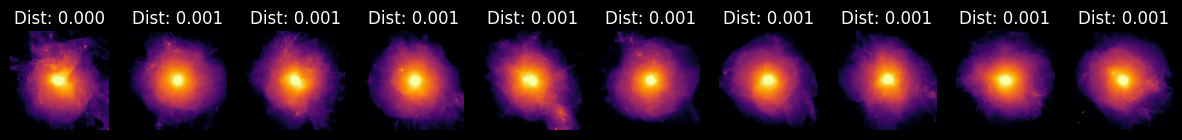

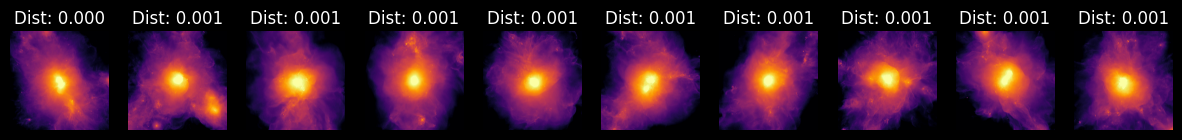

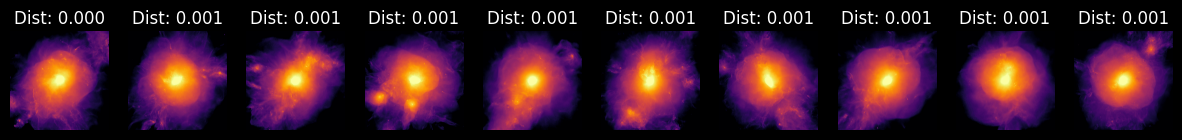

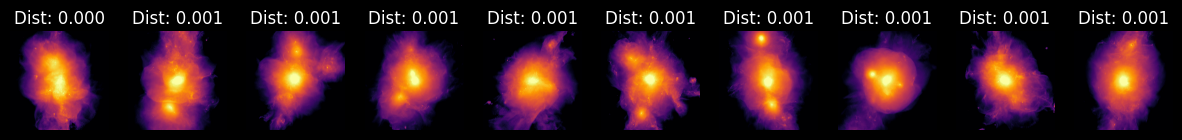

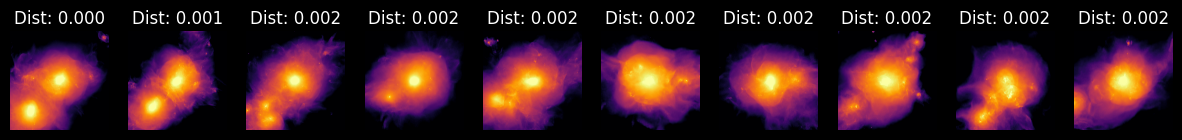

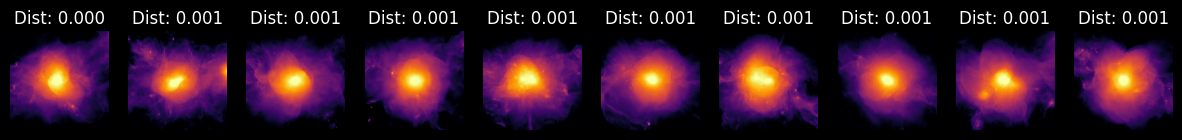

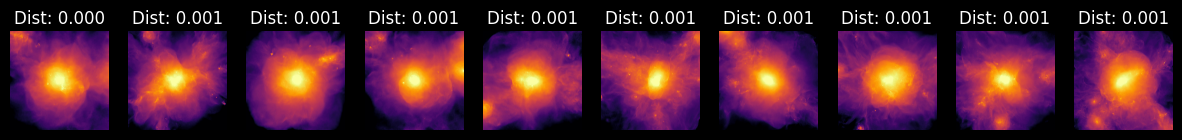

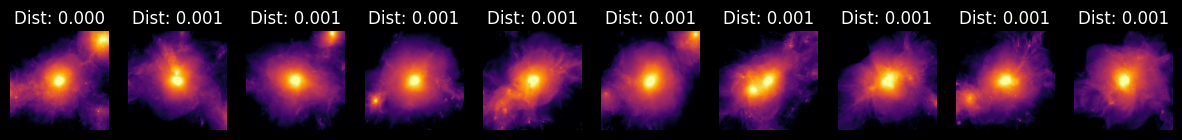

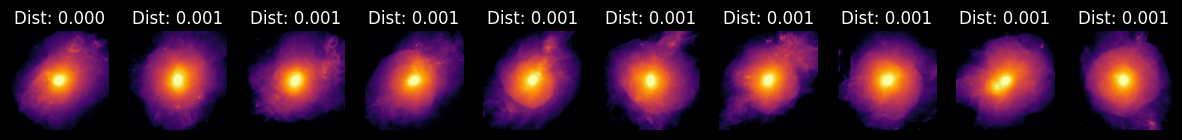

In [3]:
plot_knn_examples(embeddings, filenames, n_neighbors=10, num_examples=10)

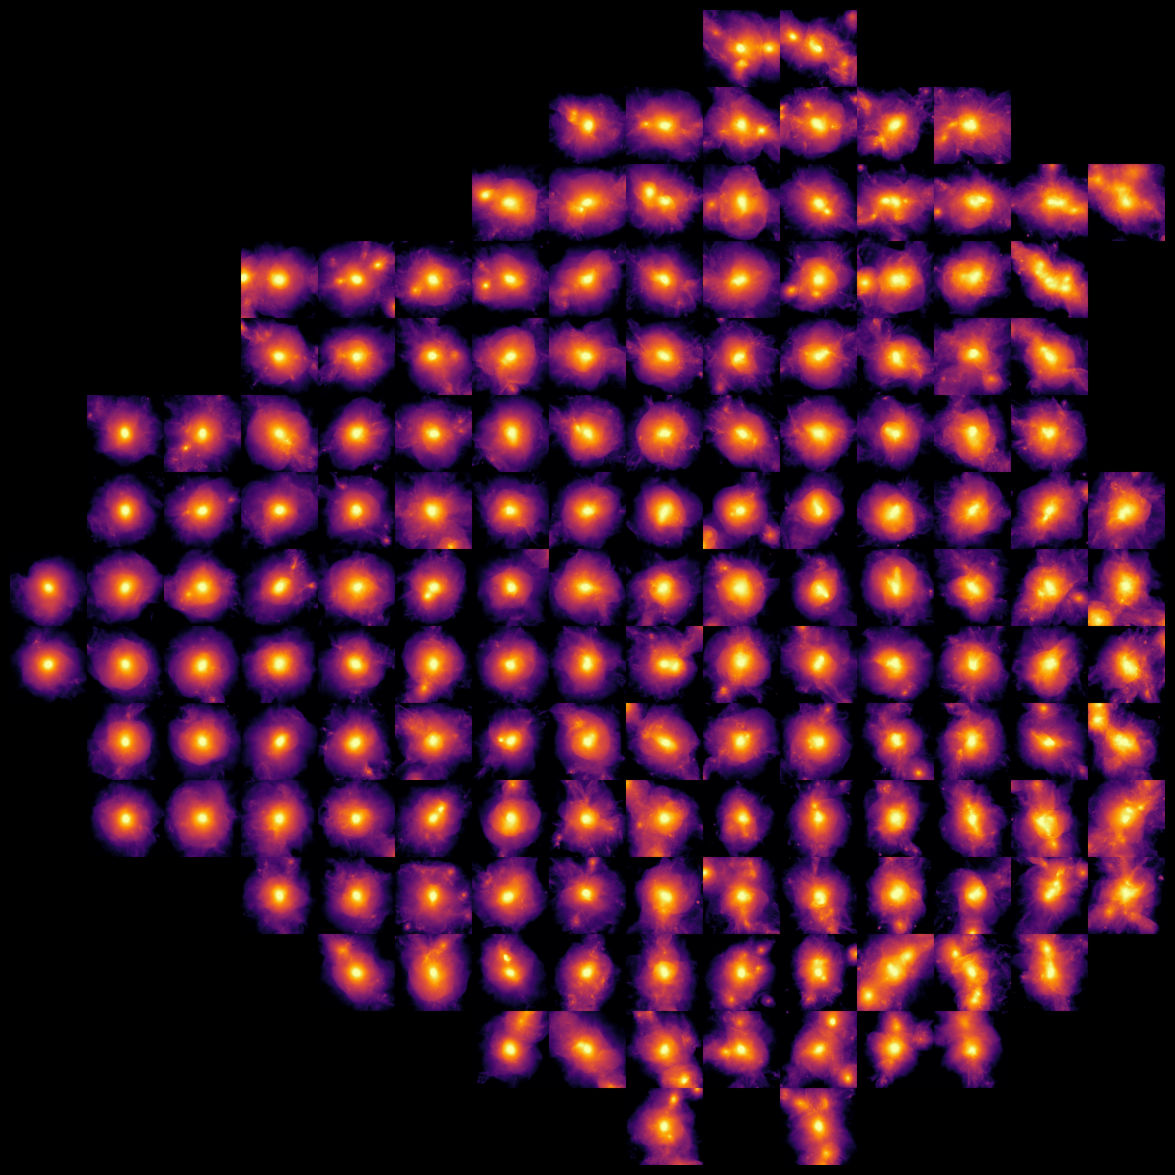

In [2]:
plot_images_on_grid(embeddings_2d, filenames, grid_size=15, cell_size=128, step=10)
